<img src="./logo_UTN.svg" align="right" width="150" /> 
#### Procesamiento Digital de Señales

# Trabajo Semanal Nº4
#### Nicolás Salvia


# Introducción
En esta tarea semanal retomamos la consigna de la tarea anterior, donde simulamos el bloque de cuantización de un ADC de B bits en un rango de  ±VF

Volts. Ahora vamos a completar la simulación del ADC incluyendo la capacidad de muestrear a fs Hertz.

Para ello se simulará el comportamiento del dispositivo al digitalizar una senoidal contaminada con un nivel predeterminado de ruido. Comenzaremos describiendo los parámetros a ajustar de la senoidal:

- frecuencia f0 arbitraria, por ejemplo f0=fS/N=Δf
- energía normalizada, es decir energía (o varianza) unitaria

Con respecto a los parámetros de la secuencia de ruido, diremos que:

- será de carácter aditivo, es decir la señal que entra al ADC será sR=s+n .Siendo n la secuencia que simula la interferencia, y s la senoidal descrita anteriormente.
- La potencia del ruido será Pn=kn.Pq W siendo el factor k una escala para la potencia del ruido de cuantización Pq=q^2/12.
- finalmente, n será incorrelado y Gaussiano.

El ADC que deseamos simular trabajará a una frecuencia de muestreo fS=1000
Hz y tendrá un rango analógico de ±VF=2 Volts.

### Señal senoidal
La señal senoidal tendra las siguientes características
- vmax = 1V
- dc = 0V
- ff = 1Hz
- ph = 0
- nn = 1000
- fs = 1000.

In [10]:
#######################################################################################################################
#%% Configuración e inicio de la simulación
#######################################################################################################################
 
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import genSign as signal_gen

def adc2_plot(B_param, kn_param):
    # Datos generales de la simulación
    fs = 1000.0 # frecuencia de muestreo (Hz)
    N = 1000   # cantidad de muestras
 
    # cantidad de veces más densa que se supone la grilla temporal para tiempo "continuo"
    over_sampling = 4
    N_os = N*over_sampling
 
    # Datos del ADC
    B = B_param # bits
    Vf = 2 # Voltss
    q = Vf/2**B # Volts
 
    # datos del ruido
    kn = kn_param
    pot_ruido = q**2/12 * kn # Watts (potencia de la señal 1 W)
 
    ts = 1/fs # tiempo de muestreo
    df = fs/N # resolución espectral
 
#######################################################################################################################
#%% Acá arranca la simulación
    analog_sig,tt = signal_gen.sin_signal(vmax = 1, dc = 0, ff = 1, ph = 0, nn = N, fs = fs)
 
    srq = np.full(
        shape = N,
        fill_value = 0,
        dtype= float)

    sr = np.full(
        shape = N,
        fill_value = 0,
        dtype= float)

    ff = np.linspace(0, (N-1), N) * df
    noise = np.random.normal(0, np.sqrt(pot_ruido), N)
    for k in range(N-1):
        sr[k] = analog_sig[k] + noise[k]
        srq[k] = np.round(sr[k]/q) * q
    
    nq = srq - sr
    ff_os = ff
    ft_Srq = 1/N * np.fft.fft(srq, axis = 0);
    ft_As = 1/N * np.fft.fft(analog_sig, axis = 0)
    ft_SR = 1/N * np.fft.fft(sr, axis = 0)
    ft_Nn = 1/N * np.fft.fft(noise, axis = 0)
    ft_Nq = 1/N * np.fft.fft(nq, axis = 0)
 
#######################################################################################################################
#%% Presentación gráfica de los resultados
    plt.close('all')
 
    plt.figure(1)
    plt.plot(tt, srq, lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)')
    plt.plot(tt, sr, linestyle=':', color='green',marker='o', markersize=3, markerfacecolor='none', markeredgecolor='green', fillstyle='none', label='$ s_R = s + n $  (ADC in)')
    plt.plot(tt, analog_sig, color='orange', ls='dotted', label='$ s $ (analog)')
 
    plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
    plt.xlabel('tiempo [segundos]')
    plt.ylabel('Amplitud [V]')
    axes_hdl = plt.gca()
    axes_hdl.legend()
    plt.show()
 
 
    plt.figure(2)
    bfrec = ff <= fs/2
 
    nNn_mean = np.mean(np.abs(ft_Nn)**2)
    Nnq_mean = np.mean(np.abs(ft_Nq)**2)
 
    plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Srq[bfrec])**2), lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)' )
    plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_As[ff_os <= fs/2])**2), color='orange', ls='dotted', label='$ s $ (analog)' )
    plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_SR[bfrec])**2), ':g', label='$ s_R = s + n $  (ADC in)' )
    plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_Nn[ff_os <= fs/2])**2), ':r')
    plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nq[bfrec])**2), ':c')
    plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([nNn_mean, nNn_mean]) ), '--r', label= '$ \overline{n} = $' + '{:3.1f} dB (piso analog.)'.format(10* np.log10(2* nNn_mean)) )
    plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([Nnq_mean, Nnq_mean]) ), '--c', label='$ \overline{n_Q} = $' + '{:3.1f} dB (piso digital)'.format(10* np.log10(2* Nnq_mean)) )
    plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
    plt.ylabel('Densidad de Potencia [dB]')
    plt.xlabel('Frecuencia [Hz]')
    axes_hdl = plt.gca()
    axes_hdl.legend()
    # suponiendo valores negativos de potencia ruido en dB
    plt.ylim((1.5*np.min(10* np.log10(2* np.array([Nnq_mean, nNn_mean]))),10))
 
 
    plt.figure(3)
    bins = 10
    plt.hist(nq, bins=bins)
    plt.plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
    plt.title( 'Ruido de cuantización para {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q))

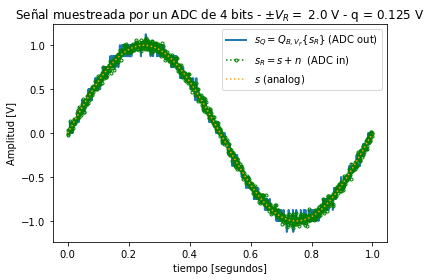

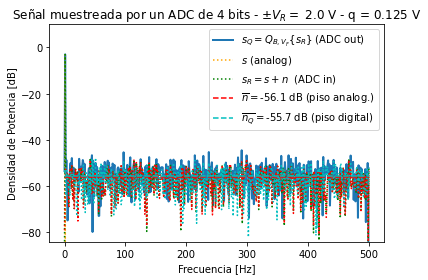

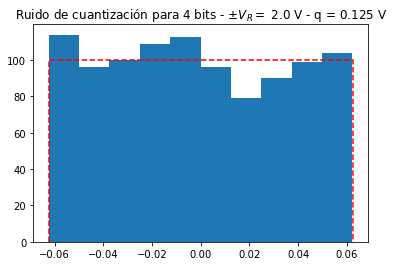

In [11]:
#Para una B = 4 y Kn = 1
adc2_plot(4, 1)

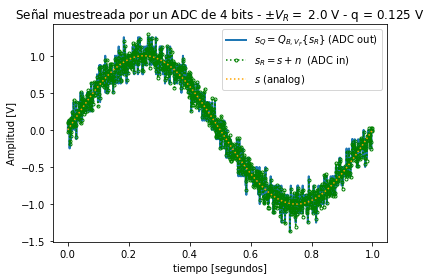

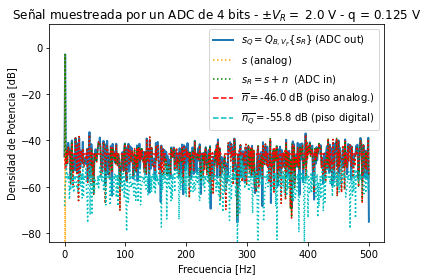

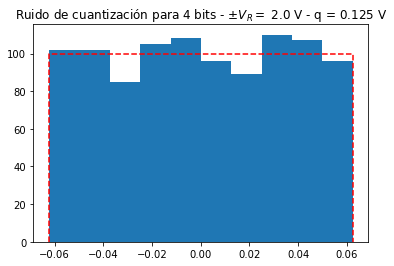

In [12]:
#Para una B = 4 y kn = 10
adc2_plot(4, 10)

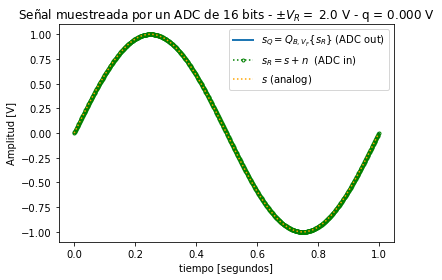

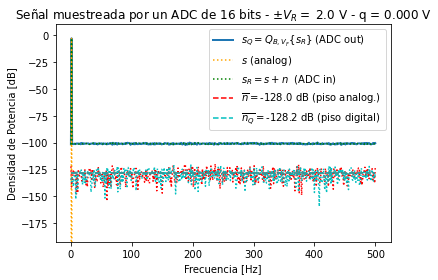

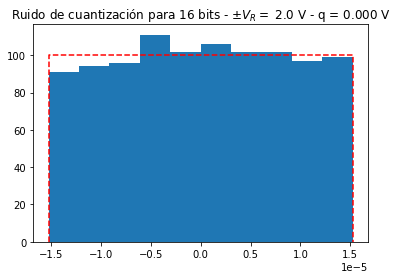

In [13]:
#Para un B = 16 y kn = 1
adc2_plot(16, 1)

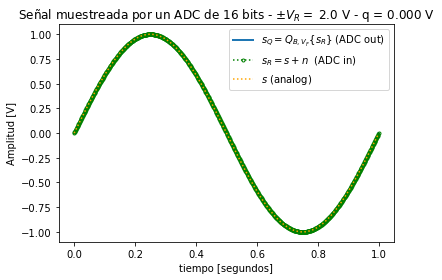

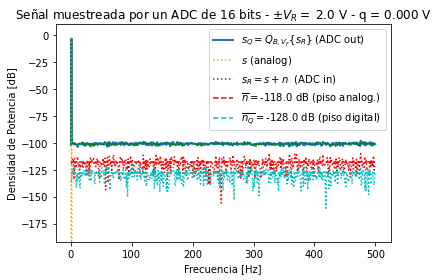

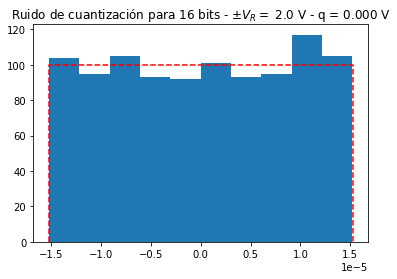

In [14]:
#Finalmente, para un B = 16 y Kn = 10
adc2_plot(16, 10)

Las conclusiones que podemos obtener es que a mayor número de bits, nuestra señal tendra una mayor densidad de potencia y sera más facil distinguirla del ruido.

### Relación entre cantidad de Bits del ADC y el SNR de la señal digitalizada

La potencia de ruido se define como:
$$
\sigma ^2_e = \frac {V_{FS}^2}{12*2^{2N}}
$$
Entonces definimos la SNR
$$
SNR = 10*log_{10} \frac{12*2^{2N}*\sigma ^2_x}{V_{FS}^2} = 6.02N + 10.79 + 20*log_{10} \frac{\sigma_x}{V_{FS}}
$$

### Aliasing

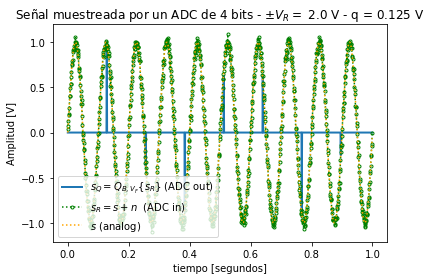

In [38]:
#######################################################################################################################
#%% Configuración e inicio de la simulación
#######################################################################################################################
 
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import genSign as signal_gen

# Datos generales de la simulación
fs = 1000.0 # frecuencia de muestreo (Hz)
N = 1000   # cantidad de muestras
 
# cantidad de veces más densa que se supone la grilla temporal para tiempo "continuo"
over_sampling = 4
N_os = N*over_sampling
 
# Datos del ADC
B = 4 # bits
Vf = 2 # Voltss
q = Vf/2**B # Volts
 
# datos del ruido
kn = 1
pot_ruido = q**2/12 * kn # Watts (potencia de la señal 1 W)
 
ts = 1/fs # tiempo de muestreo
df = fs/N # resolución espectral
 
#######################################################################################################################
#%% Acá arranca la simulación
analog_sig,tt_original = signal_gen.sin_signal(vmax = 1, dc = 0, ff = 10, ph = 0, nn = N, fs = fs)
 
srq = np.full(
        shape = N,
        fill_value = 0,
        dtype= float)

sr = np.full(
        shape = N,
        fill_value = 0,
        dtype= float)

ff = np.linspace(0, (N-1), N) * df
noise = np.random.normal(0, np.sqrt(pot_ruido), N)

for k in range(N-1):
    sr[k] = analog_sig[k] + noise[k]

for k in range(0, N-1, 128):
    srq[k] = np.round(sr[k]/q) * q
     
#######################################################################################################################
#%% Presentación gráfica de los resultados
plt.close('all')
 
plt.figure(1)
plt.plot(tt, srq, lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)')
plt.plot(tt, sr, linestyle=':', color='green',marker='o', markersize=3, markerfacecolor='none', markeredgecolor='green', fillstyle='none', label='$ s_R = s + n $  (ADC in)')
plt.plot(tt, analog_sig, color='orange', ls='dotted', label='$ s $ (analog)')
 
plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')
axes_hdl = plt.gca()
axes_hdl.legend()
plt.show()